In [1]:
!pip install --quiet --upgrade tensorflow-federated-nightly
!pip install --quiet --upgrade nest-asyncio
!pip install --quiet --upgrade tb-nightly  

import nest_asyncio
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

nest_asyncio.apply()

@tff.federated_computation
def start():
  return 'Federated learning + differential privacy'

start()

     |████████████████████████████████| 821 kB 5.2 MB/s 
     |████████████████████████████████| 238 kB 34.8 MB/s 
     |████████████████████████████████| 542.7 MB 21 kB/s 
     |████████████████████████████████| 4.2 MB 51.0 MB/s 
     |████████████████████████████████| 887 kB 36.3 MB/s 
     |████████████████████████████████| 65.1 MB 90 kB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 126 kB 60.8 MB/s 
     |████████████████████████████████| 251 kB 45.7 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 121 kB 57.2 MB/s 
     |████████████████████████████████| 6.0 MB 38.0 MB/s 
     |████████████████████████████████| 1.7 MB 59.5 MB/s 
     |████████████████████████████████| 542.6 MB 27 kB/s 
     |████████████████████████████████| 542.7 MB 17 kB/s 
     |████████████████████████████████| 543.0 MB 28 kB/s 
     |████████████████████████████████| 542.8 MB 3.4 kB/s 
     |█████████████

b'Federated learning + differential privacy'

Type of structure:
Number of clients in training data
Number of clients in testing data


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


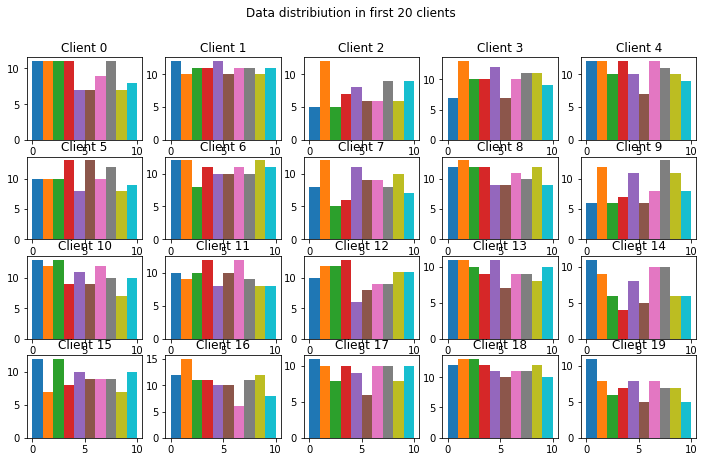

In [2]:
train, test = tff.simulation.datasets.emnist.load_data(only_digits = True)

print("Type of structure:") 
train.element_type_structure

print("Number of clients in training data") 
len(train.client_ids)

print("Number of clients in testing data") 
len(test.client_ids)


figure_1 = plt.figure(figsize=(12, 7))
figure_1.suptitle('Data distribiution in first 20 clients')
for i in range(20):
  first_clients_data = train.create_tf_dataset_for_client(train.client_ids[i])
  plot_per_user = collections.defaultdict(list)
  for example in first_clients_data:
    label = example['label'].numpy()
    plot_per_user[label].append(label)
  plt.subplot(4, 5, i+1)
  plt.title('Client {}'.format(i))
  for number in range(10):
    plt.hist(
        plot_per_user[number],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

def get_emnist_data():
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
      only_digits=True)

  def element_change_expand(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

  def train_preprocess(dataset):
    return (dataset.map(element_change_expand)
                   .shuffle(buffer_size=418)
                   .repeat(1)
                   .batch(32, drop_remainder=False))

  def test_preprocess(dataset):
    return dataset.map(element_change_expand).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(train_preprocess)
  emnist_test = test_preprocess(
      emnist_test.create_tf_dataset_from_all_clients())
  return emnist_train, emnist_test

emnist_train, emnist_test = get_emnist_data()

def my_model_fn():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)])
  return tff.learning.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=emnist_test.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

tff.backends.native.set_local_python_execution_context(clients_per_thread=10)

total_clients = len(emnist_train.client_ids)

def train(rounds, noise_multiplier, clients_per_round, input_data_frame):
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  sampling_prob = clients_per_round / total_clients

  learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        my_model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_aggregator=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn)

  state = learning_process.initialize()
  for round in range(rounds):
    if round % 2 == 0:
      model_weights = learning_process.get_model_weights(state)
      metrics = eval_process(model_weights, [emnist_test])['eval']
      print(f'Round {round:3d}: {metrics}')
      input_data_frame = input_data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)
    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        emnist_train.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        emnist_train.create_tf_dataset_for_client(client)
        for client in sampled_clients]

    result = learning_process.next(state, sampled_train_data)
    state = result.state
    metrics = result.metrics

  model_weights = learning_process.get_model_weights(state)
  metrics = eval_process(model_weights, [emnist_test])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  input_data_frame = input_data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return input_data_frame

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

rdp_orders = ([1.25, 1.5, 1.75, 2., 2.25, 2.5, 3., 3.5, 4., 4.5] +
              list(range(5, 64)) + [128, 256, 512])

def finding_num_of_clients(total_clients, base_noise_multiplier, base_clients_per_round, target_delta, target_eps, what):

  def get_epsilon(clients_per_round):
    q = clients_per_round / total_clients
    noise_multiplier = base_noise_multiplier
    noise_multiplier *= clients_per_round / base_clients_per_round
    rdp = tfp.compute_rdp(
        q, noise_multiplier=noise_multiplier, steps=rounds, orders=rdp_orders)
    eps, _, _ = tfp.get_privacy_spent(rdp_orders, rdp, target_delta=target_delta)
    return clients_per_round, eps, noise_multiplier

  def find_needed_clients_per_round():
    epsilon = get_epsilon(base_clients_per_round)
    if epsilon[1] < target_eps:
      return epsilon
    
    while True:
      lo = epsilon
      epsilon = get_epsilon(2 * lo[0])
      if epsilon[1] < target_eps:
        break

    while epsilon[0] - lo[0] > 1:
      mid = get_epsilon((lo[0] + epsilon[0]) // 2)
      if mid[1] > target_eps:
        lo = mid
      else:
        epsilon = mid

    return epsilon

  clients_per_round, _, noise_multiplier = find_needed_clients_per_round()
  print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
        f'clients with noise multiplier {noise_multiplier}.')
  if what == 'eps':
    return [noise_multiplier, clients_per_round]
  else:
    return [noise_multiplier, clients_per_round]

In [9]:
total_clients = 3383
base_noise_multiplier = 0.5
base_clients_per_round = 50
base_target_delta = 1e-5
base_target_eps = 2
rounds = 2

target_eps = [1.3, 1.4, 1.5, 1.6, 1.8, 2 ,3, 4, 5, 6, 10, 15] 
target_eps_clients = []
target_eps_noise = []

for epsilon in target_eps:
  [noise, client] = finding_num_of_clients(total_clients, base_noise_multiplier, base_clients_per_round, base_target_delta, epsilon, 'eps')
  target_eps_clients.append(client)
  target_eps_noise.append(noise)



To get (1.3, 1e-05)-DP, use 104 clients with noise multiplier 1.04.
To get (1.4, 1e-05)-DP, use 101 clients with noise multiplier 1.01.
To get (1.5, 1e-05)-DP, use 97 clients with noise multiplier 0.97.
To get (1.6, 1e-05)-DP, use 94 clients with noise multiplier 0.94.
To get (1.8, 1e-05)-DP, use 91 clients with noise multiplier 0.91.
To get (2, 1e-05)-DP, use 83 clients with noise multiplier 0.83.
To get (3, 1e-05)-DP, use 68 clients with noise multiplier 0.68.
To get (4, 1e-05)-DP, use 59 clients with noise multiplier 0.59.
To get (5, 1e-05)-DP, use 53 clients with noise multiplier 0.53.
To get (6, 1e-05)-DP, use 50 clients with noise multiplier 0.5.
To get (10, 1e-05)-DP, use 50 clients with noise multiplier 0.5.
To get (15, 1e-05)-DP, use 50 clients with noise multiplier 0.5.


In [4]:
print(target_eps_clients)
print(target_eps_noise)
print(target_eps)

[104, 101, 97, 94, 91, 83, 68, 59, 53, 50, 50, 50]
[1.04, 1.01, 0.97, 0.94, 0.91, 0.83, 0.68, 0.59, 0.53, 0.5, 0.5, 0.5]
[1.3, 1.4, 1.5, 1.6, 1.8, 2, 3, 4, 5, 6, 10, 15]


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.098770574), ('loss', 2.5631597), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.14091888), ('loss', 2.326381), ('num_examples', 40832), ('num_batches', 319)])


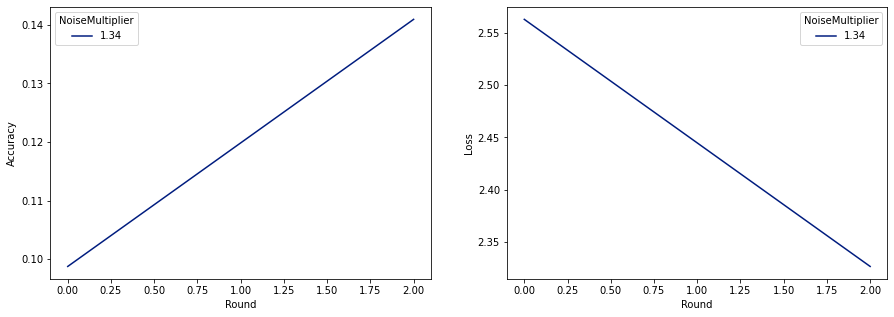

In [5]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 1.34, 134, data_frame_buffor)

  make_plot(data_frame_buffor)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10560345), ('loss', 2.671713), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.21923982), ('loss', 2.2877007), ('num_examples', 40832), ('num_batches', 319)])


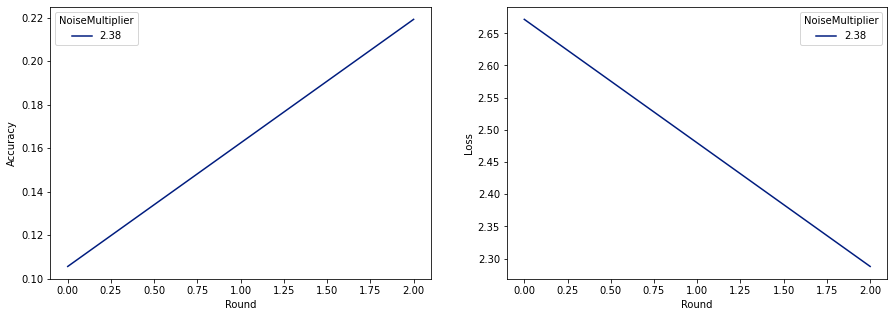

In [6]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 2.38, 238, data_frame_buffor)

  make_plot(data_frame_buffor)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09913793), ('loss', 3.0892954), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.13239616), ('loss', 2.3605173), ('num_examples', 40832), ('num_batches', 319)])


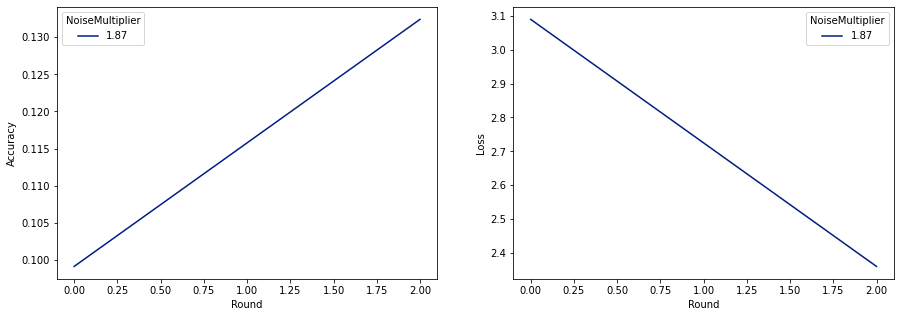

In [7]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 1.87, 187, data_frame_buffor)

  make_plot(data_frame_buffor)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.08939067), ('loss', 2.52664), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.10484424), ('loss', 2.3456218), ('num_examples', 40832), ('num_batches', 319)])


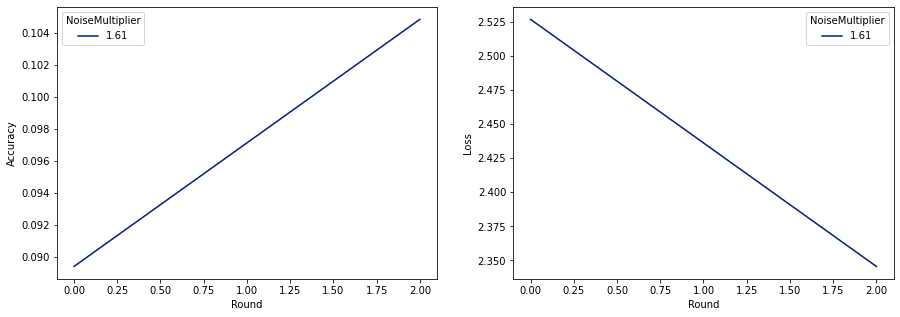

In [8]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 1.61, 161, data_frame_buffor)

  make_plot(data_frame_buffor)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10562794), ('loss', 2.4259965), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.17351587), ('loss', 2.3109553), ('num_examples', 40832), ('num_batches', 319)])
Round   4: OrderedDict([('sparse_categorical_accuracy', 0.18642241), ('loss', 2.2369936), ('num_examples', 40832), ('num_batches', 319)])
Round   6: OrderedDict([('sparse_categorical_accuracy', 0.11931818), ('loss', 2.2437696), ('num_examples', 40832), ('num_batches', 319)])
Round   8: OrderedDict([('sparse_categorical_accuracy', 0.37333465), ('loss', 2.1646092), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.23146062), ('loss', 2.135814), ('num_examples', 40832), ('num_batches', 319)])
Round  12: OrderedDict([('sparse_categorical_accuracy', 0.42275667), ('loss', 2.0713453), ('num_examples', 40832), ('num_batches', 319)])
Round  14: OrderedDict([('sparse_ca

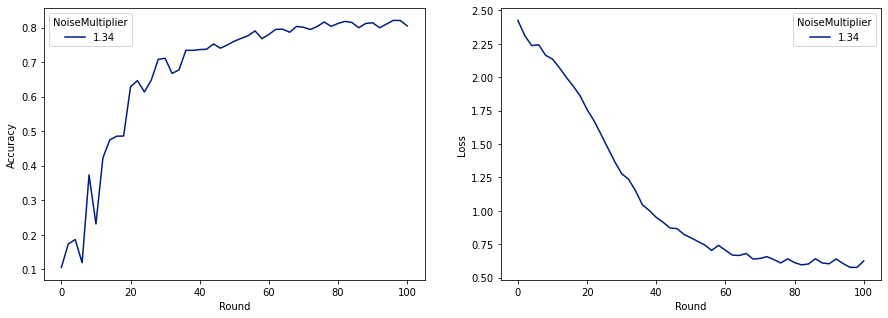

In [ ]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 1.34, 134, data_frame_buffor)

  make_plot(data_frame_buffor)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10014205), ('loss', 2.4688087), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.11704056), ('loss', 2.3127027), ('num_examples', 40832), ('num_batches', 319)])
Round   4: OrderedDict([('sparse_categorical_accuracy', 0.12323668), ('loss', 2.285759), ('num_examples', 40832), ('num_batches', 319)])
Round   6: OrderedDict([('sparse_categorical_accuracy', 0.22423589), ('loss', 2.2399132), ('num_examples', 40832), ('num_batches', 319)])
Round   8: OrderedDict([('sparse_categorical_accuracy', 0.274711), ('loss', 2.2061617), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.2684659), ('loss', 2.1746933), ('num_examples', 40832), ('num_batches', 319)])
Round  12: OrderedDict([('sparse_categorical_accuracy', 0.3700529), ('loss', 2.11126), ('num_examples', 40832), ('num_batches', 319)])
Round  14: OrderedDict([('sparse_categori

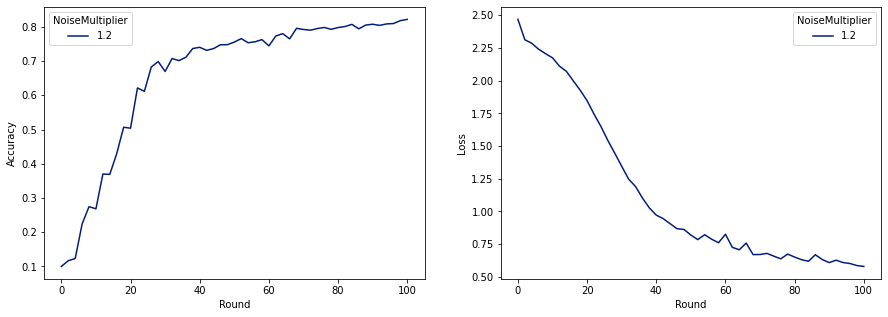

In [ ]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 1.2, 120, data_frame_buffor)

  make_plot(data_frame_buffor)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10293397), ('loss', 2.6416152), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.11522825), ('loss', 2.339233), ('num_examples', 40832), ('num_batches', 319)])
Round   4: OrderedDict([('sparse_categorical_accuracy', 0.21884796), ('loss', 2.2710848), ('num_examples', 40832), ('num_batches', 319)])
Round   6: OrderedDict([('sparse_categorical_accuracy', 0.23013812), ('loss', 2.2672324), ('num_examples', 40832), ('num_batches', 319)])
Round   8: OrderedDict([('sparse_categorical_accuracy', 0.22903605), ('loss', 2.193127), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.3289087), ('loss', 2.1413517), ('num_examples', 40832), ('num_batches', 319)])
Round  12: OrderedDict([('sparse_categorical_accuracy', 0.2723599), ('loss', 2.0954905), ('num_examples', 40832), ('num_batches', 319)])
Round  14: OrderedDict([('sparse_categ

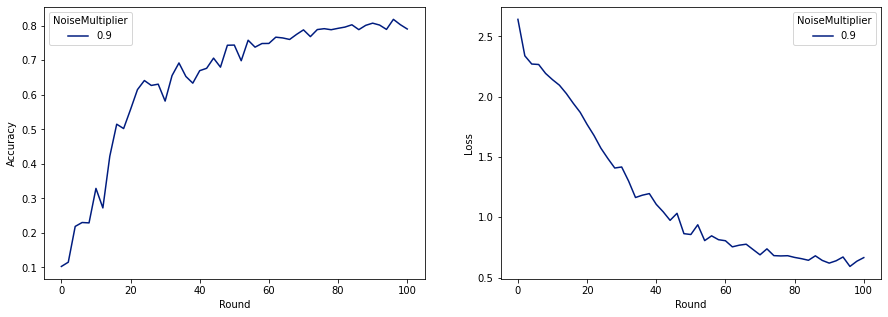

In [ ]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 0.9, 90, data_frame_buffor)

  make_plot(data_frame_buffor)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09752155), ('loss', 2.8255272), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.096541926), ('loss', 2.352484), ('num_examples', 40832), ('num_batches', 319)])
Round   4: OrderedDict([('sparse_categorical_accuracy', 0.09950529), ('loss', 2.3443165), ('num_examples', 40832), ('num_batches', 319)])
Round   6: OrderedDict([('sparse_categorical_accuracy', 0.18551627), ('loss', 2.2878313), ('num_examples', 40832), ('num_batches', 319)])
Round   8: OrderedDict([('sparse_categorical_accuracy', 0.28196022), ('loss', 2.2228153), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.23868534), ('loss', 2.1707962), ('num_examples', 40832), ('num_batches', 319)])
Round  12: OrderedDict([('sparse_categorical_accuracy', 0.16080526), ('loss', 2.1356938), ('num_examples', 40832), ('num_batches', 319)])
Round  14: OrderedDict([('sparse_c

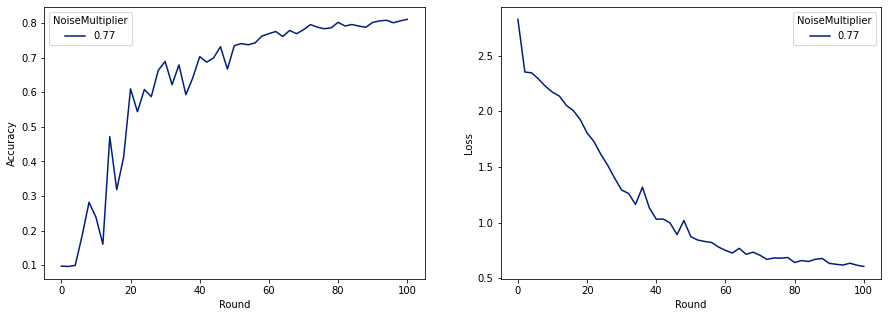

In [ ]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 0.77, 77, data_frame_buffor)

  make_plot(data_frame_buffor)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09575823), ('loss', 2.8888316), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.11334248), ('loss', 2.3453553), ('num_examples', 40832), ('num_batches', 319)])
Round   4: OrderedDict([('sparse_categorical_accuracy', 0.17253624), ('loss', 2.286764), ('num_examples', 40832), ('num_batches', 319)])
Round   6: OrderedDict([('sparse_categorical_accuracy', 0.22504409), ('loss', 2.2764878), ('num_examples', 40832), ('num_batches', 319)])
Round   8: OrderedDict([('sparse_categorical_accuracy', 0.25455526), ('loss', 2.1887174), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.31551233), ('loss', 2.1451597), ('num_examples', 40832), ('num_batches', 319)])
Round  12: OrderedDict([('sparse_categorical_accuracy', 0.40316418), ('loss', 2.0780256), ('num_examples', 40832), ('num_batches', 319)])
Round  14: OrderedDict([('sparse_ca

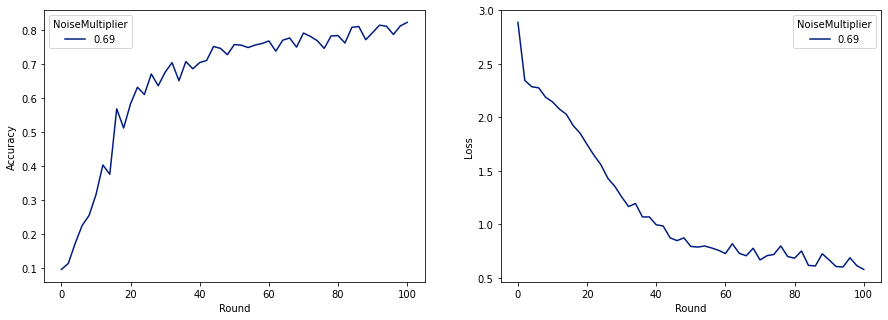

In [ ]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 0.69, 69, data_frame_buffor)

  make_plot(data_frame_buffor)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09580721), ('loss', 2.6400294), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.0986971), ('loss', 2.346448), ('num_examples', 40832), ('num_batches', 319)])
Round   4: OrderedDict([('sparse_categorical_accuracy', 0.12482856), ('loss', 2.29428), ('num_examples', 40832), ('num_batches', 319)])
Round   6: OrderedDict([('sparse_categorical_accuracy', 0.19342673), ('loss', 2.2783802), ('num_examples', 40832), ('num_batches', 319)])
Round   8: OrderedDict([('sparse_categorical_accuracy', 0.26236776), ('loss', 2.207151), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.20158209), ('loss', 2.171522), ('num_examples', 40832), ('num_batches', 319)])
Round  12: OrderedDict([('sparse_categorical_accuracy', 0.40453565), ('loss', 2.0910008), ('num_examples', 40832), ('num_batches', 319)])
Round  14: OrderedDict([('sparse_categor

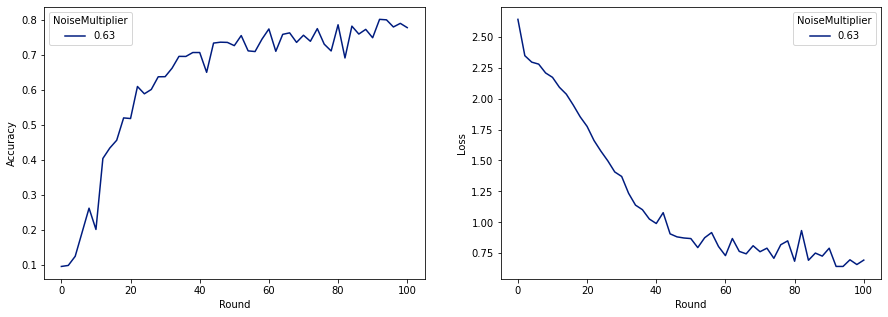

In [ ]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 0.63, 63, data_frame_buffor)

  make_plot(data_frame_buffor)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.06879409), ('loss', 2.447835), ('num_examples', 40832), ('num_batches', 319)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.11948962), ('loss', 2.338356), ('num_examples', 40832), ('num_batches', 319)])
Round   4: OrderedDict([('sparse_categorical_accuracy', 0.18341006), ('loss', 2.2542546), ('num_examples', 40832), ('num_batches', 319)])
Round   6: OrderedDict([('sparse_categorical_accuracy', 0.18918985), ('loss', 2.2431686), ('num_examples', 40832), ('num_batches', 319)])
Round   8: OrderedDict([('sparse_categorical_accuracy', 0.2830133), ('loss', 2.1781485), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.3036834), ('loss', 2.144896), ('num_examples', 40832), ('num_batches', 319)])
Round  12: OrderedDict([('sparse_categorical_accuracy', 0.40845415), ('loss', 2.0891113), ('num_examples', 40832), ('num_batches', 319)])
Round  14: OrderedDict([('sparse_catego

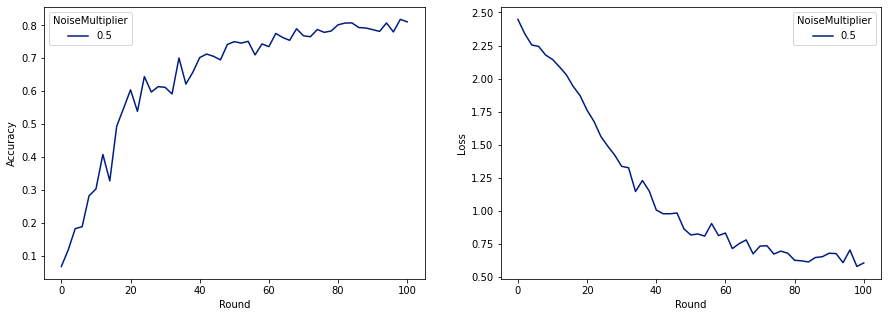

In [ ]:
  data_frame_buffor = pd.DataFrame()
  data_frame_buffor = train(rounds, 0.5, 50, data_frame_buffor)

  make_plot(data_frame_buffor)